In [1]:
%matplotlib inline
import numpy as np 
from matplotlib import pyplot as plt
from skyfield import almanac, api, data
import skychart

In [2]:
plt.rcParams['figure.figsize'] = [15, 15]

In [3]:
load = api.Loader('./data')

In [4]:
manhattan_beach = api.Topos('33.881519 N', '118.388177 W')

In [5]:
ts = load.timescale()

In [6]:
ephemeris = load('de421.bsp')

In [7]:
t0 = ts.utc(2019, 1, 1)
t1 = ts.utc(2019, 12, 31)
t, y = almanac.find_discrete(t0, t1, almanac.seasons(ephemeris))

for yi, ti in zip(y, t):
    print(yi, almanac.SEASON_EVENTS[yi], ti.utc_iso(' '))

0 Vernal Equinox 2019-03-20 21:58:26Z
1 Summer Solstice 2019-06-21 15:54:15Z
2 Autumnal Equinox 2019-09-23 07:50:11Z
3 Winter Solstice 2019-12-22 04:19:26Z


In [8]:
t0 = ts.utc(2019, 5, 25, 4)
t1 = ts.utc(2019, 5, 26, 4)
t, y = almanac.find_discrete(t0, t1, almanac.sunrise_sunset(ephemeris, manhattan_beach))

print(t.utc_iso())
print(y)

['2019-05-25T12:46:26Z', '2019-05-26T02:54:55Z']
[ True False]


In [9]:
t0 = ts.utc(2019, 5, 1)
t1 = ts.utc(2019, 5, 31)
t, y = almanac.find_discrete(t0, t1, almanac.moon_phases(ephemeris))

print(t.utc_iso())
print(y)
print([ almanac.MOON_PHASES[yi] for yi in y ])

['2019-05-04T22:45:30Z', '2019-05-12T01:12:14Z', '2019-05-18T21:11:21Z', '2019-05-26T16:33:35Z']
[0 1 2 3]
['New Moon', 'First Quarter', 'Full Moon', 'Last Quarter']


In [10]:
with load.open(data.hipparcos.URL) as f:
    df = data.hipparcos.load_dataframe(f)
    
barnards_star = api.Star.from_dataframe(df.loc[87937])

In [11]:
earth = ephemeris['earth']
t = ts.now()
astrometric = earth.at(t).observe(barnards_star)
ra, dec, distance = astrometric.radec()
print(ra, dec, distance)

17h 57m 47.46s +04deg 44' 57.3" 2.06265e+14 au


In [12]:
df.head()

,magnitude,ra_degrees,dec_degrees,parallax_mas,ra_mas_per_year,dec_mas_per_year,ra_hours,epoch_year
hip,,,,,,,,
1,9.10,0.000912,1.089013,3.54,-5.20,-1.88,0.000061,1991.25
2,9.27,0.003797,-19.498837,21.90,181.21,-0.93,0.000253,1991.25
3,6.61,0.005008,38.859286,2.81,5.24,-2.91,0.000334,1991.25
4,8.06,0.008382,-51.893546,7.75,62.85,0.16,0.000559,1991.25
5,8.55,0.009965,-40.591224,2.87,2.53,9.07,0.000664,1991.25


In [13]:
bright = df[df['magnitude'] <= 5.5]

In [14]:
len(bright)

2851

In [15]:
bright.head(10)

,magnitude,ra_degrees,dec_degrees,parallax_mas,ra_mas_per_year,dec_mas_per_year,ra_hours,epoch_year
hip,,,,,,,,
122,4.78,0.399379,-77.065294,14.77,-56.52,-176.95,0.026625,1991.25
145,5.13,0.455989,-3.027479,7.98,18.90,-10.25,0.030399,1991.25
154,4.37,0.489965,-6.013972,7.86,46.62,-41.32,0.032664,1991.25
183,5.04,0.582976,-29.720448,6.40,9.66,14.00,0.038865,1991.25
301,4.55,0.934885,-17.335970,14.31,28.57,-7.28,0.062326,1991.25
355,4.99,1.125510,-10.509494,2.03,-6.49,-11.88,0.075034,1991.25
443,4.61,1.333941,-5.707833,25.38,-8.29,88.19,0.088929,1991.25
677,2.07,2.096533,29.090828,33.60,135.68,-162.95,0.139769,1991.25
746,2.28,2.292040,59.150218,59.89,523.39,-180.42,0.152803,1991.25


In [16]:
bright_stars = api.Star.from_dataframe(bright)

In [17]:
t = ts.now()
astrometric = earth.at(t).observe(bright_stars)
ra, dec, distance = astrometric.radec()

In [18]:
def magnitude_to_marker_size(v_mag):
    """Calculate the size of a matplotlib plot marker representing an object with                                       
    a given visual megnitude.                                                                                           
                                                                                                                        
    A third-degree polynomial was fit to a few hand-curated examples of                                                 
    marker sizes for magnitudes, as follows:                                                                            
                                                                                                                        
    >>> x = np.array([-1.44, -0.5, 0., 1., 2., 3., 4., 5.])                                                             
    >>> y = np.array([120., 90., 60., 30., 15., 11., 6., 1.])                                                           
    >>> coeffs = np.polyfit(x, y, 3)                                                                                    
                                                                                                                        
    This function is valid over the range -2.0 < v <= 6.0; v < -2.0 returns                                             
    size = 160. and v > 6.0 returns size = 1.                                                                           
                                                                                                                        
    Args:                                                                                                               
        v_mag: A float representing the visual magnitude of a sky object.                                               
                                                                                                                        
    Returns:                                                                                                            
        A float to be used as the size of a marker depicting the sky object in a                                        
            matplotlib.plt scatterplot.                                                                                 
    """

    if v_mag < -2.0:
        size = 160.0
    elif v_mag > 6.0:
        size = 1.0
    else:
        coeffs = [-0.39439046, 6.21313285, -33.09853387, 62.07732768]
        size = coeffs[0] * v_mag**3. + coeffs[1] * v_mag**2. + coeffs[2] * v_mag + coeffs[3]
    return size

In [19]:
mags = bright['magnitude'].tolist()
sizes = [ magnitude_to_marker_size(float(v)) for v in mags ]

In [20]:
magnitude_to_marker_size(-2)

156.2820505

[]

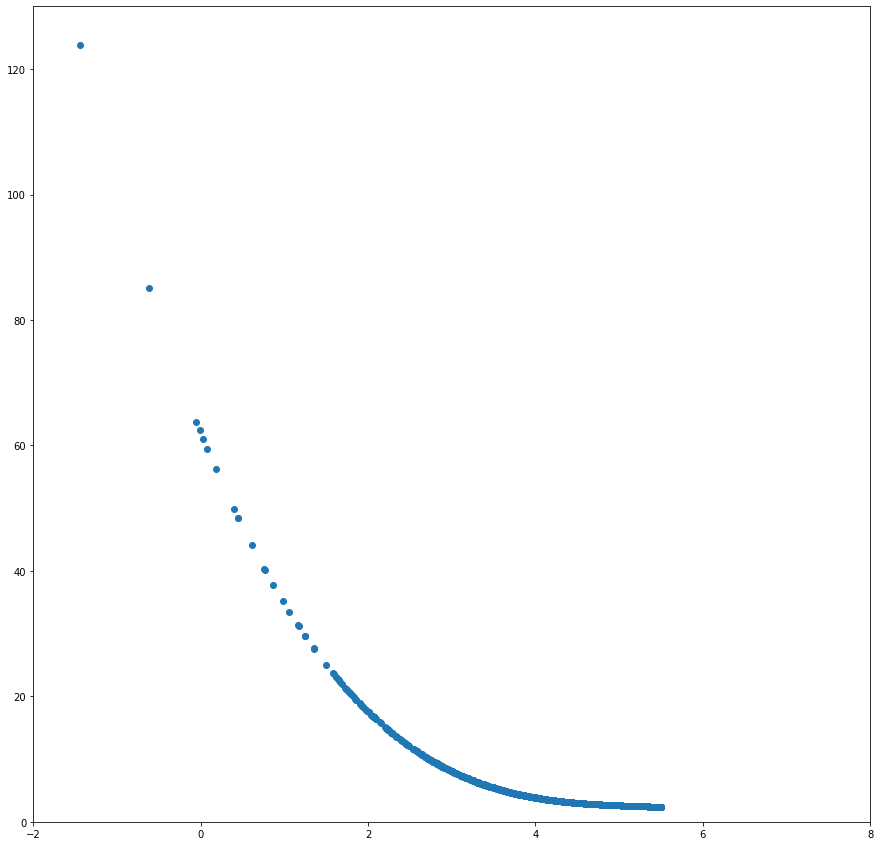

In [21]:
plt.scatter(mags, sizes)
plt.xlim(-2., 8.)
plt.ylim(0., 130.)
plt.plot()

[]

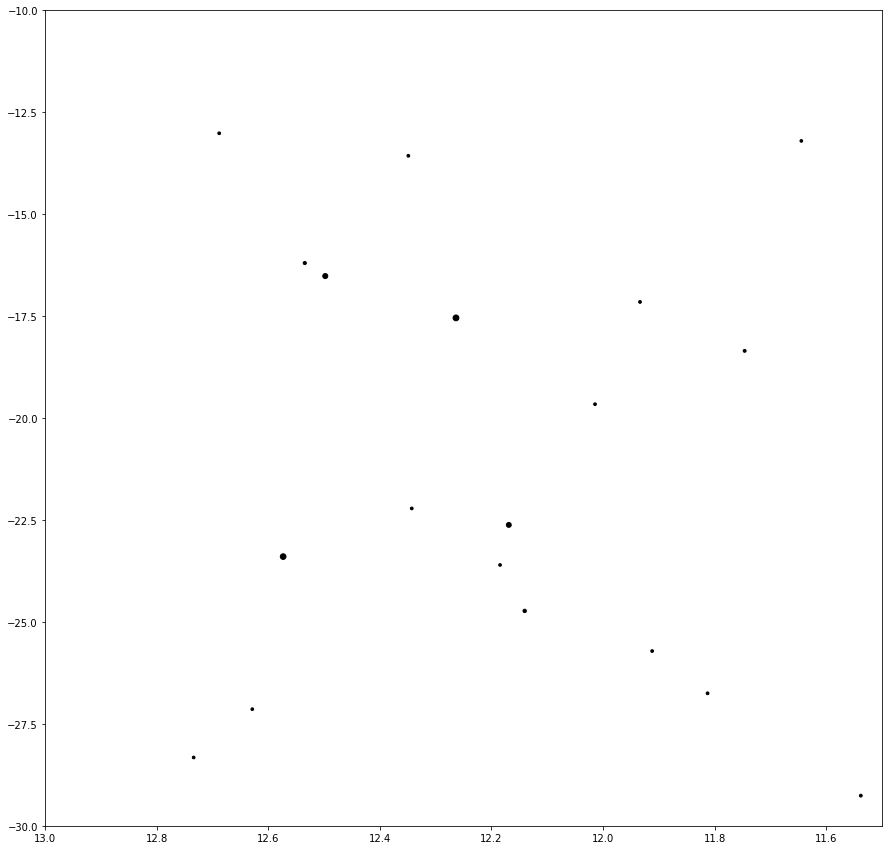

In [22]:
plt.scatter(ra.hours, dec.degrees, [ magnitude_to_marker_size(v)*3 for v in mags ], 'k')
plt.xlim(13.0, 11.5)
plt.ylim(-30, -10)
plt.plot()

In [23]:
observer = earth + manhattan_beach
theta, r, mag = [], [], []
for i in range(len(bright)):
    star = api.Star.from_dataframe(bright.iloc[i])
    app = observer.at(t).observe(star).apparent()
    alt, az, _ = app.altaz()
    theta.append(az.radians)
    r.append(alt.degrees)
    mag.append(bright.iloc[i]['magnitude'])

In [24]:
observer = earth + manhattan_beach
sun_apparent = observer.at(t).observe(ephemeris['sun']).apparent()
sun_alt, sun_az, _ = sun_apparent.altaz()
moon_apparent = observer.at(t).observe(ephemeris['moon']).apparent()
moon_alt, moon_az, _ = moon_apparent.altaz()
mercury_apparent = observer.at(t).observe(ephemeris['mercury']).apparent()
mercury_alt, mercury_az, _ = mercury_apparent.altaz()
venus_apparent = observer.at(t).observe(ephemeris['venus']).apparent()
venus_alt, venus_az, _ = venus_apparent.altaz()
mars_apparent = observer.at(t).observe(ephemeris['mars']).apparent()
mars_alt, mars_az, _ = mars_apparent.altaz()
jupiter_apparent = observer.at(t).observe(ephemeris['JUPITER BARYCENTER']).apparent()
jupiter_alt, jupiter_az, _ = jupiter_apparent.altaz()
saturn_apparent = observer.at(t).observe(ephemeris['SATURN BARYCENTER']).apparent()
saturn_alt, saturn_az, _ = saturn_apparent.altaz()

/Users/allenb/anaconda/envs/astro/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


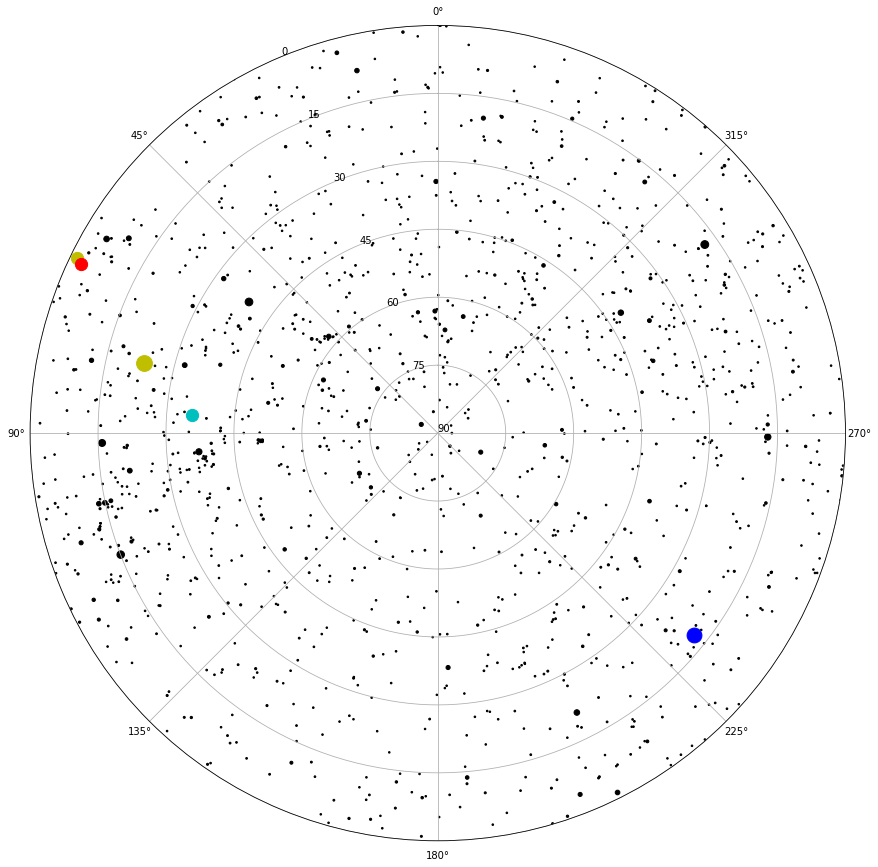

In [27]:
ax = plt.subplot(111, projection='polar')
ax.set_rlim(0, 90)
ax.set_theta_zero_location('N')
ax.set_theta_direction(1)
ax.set_yticks(np.arange(0, 105, 15))
ax.set_yticklabels(ax.get_yticks()[::-1])
plt.scatter(np.array(theta), 90.-np.array(r), [ skychart._magnitude_to_marker_size(v) for v in mag ], 'k')
plt.scatter(sun_az.radians, 90.-sun_alt.degrees, 250, 'y')
plt.scatter(moon_az.radians, 90.-moon_alt.degrees, 220, 'b')
plt.scatter(mercury_az.radians, 90.-mercury_alt.degrees, 150, 'y')
plt.scatter(venus_az.radians, 90.-venus_alt.degrees, 150, 'c')
plt.scatter(mars_az.radians, 90.-mars_alt.degrees, 150, 'r')
plt.scatter(jupiter_az.radians, 90.-jupiter_alt.degrees, 150, 'y')
plt.scatter(saturn_az.radians, 90.-saturn_alt.degrees, 150, 'y')
plt.show()